### 07. Get general statistics.

---
1. Number of days players played the game
* Number of matches played by date
* Number of cheaters by ban date

In [ ]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Read telemetry data stored in my S3 bucket.
td = spark.read.parquet("s3://social-research-cheating/raw_td.parquet")
td.registerTempTable("td")

# Read a table that contains player data.
players = spark.read.parquet("s3://social-research-cheating/nodes.parquet")
players.registerTempTable("players")

# Read a table that contains cheater data.
# spark.read.parquet("s3://social-research-cheating/cheater_info.parquet").createOrReplaceTempView("cheaters")

### Calculate the win rates of (non-)cheaters.

In [ ]:
cheater_matches = spark.read.parquet("s3://social-research-cheating/general-stats/num_of_cheaters_per_match.parquet")
cheater_matches.registerTempTable("cheater_matches")
cheater_matches.show(5)

# First, get the logs of matches in which at least one cheater took part.
match_logs = spark.sql("SELECT t.*, mod FROM td t JOIN cheater_matches c ON t.mid = c.mid")
match_logs.write.parquet("s3://social-research-cheating/general-stats/matches_with_cheaters.parquet")

In [ ]:
match_logs = spark.read.parquet("s3://social-research-cheating/general-stats/matches_with_cheaters.parquet")
match_logs.registerTempTable("match_logs")

# Add more information about killers and victims.
add_src_flags = spark.sql("""SELECT mid, src, 
                             CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END AS src_curr_flag, 
                             dst, time, m_date, mod 
                             FROM match_logs r LEFT JOIN players p ON r.src = p.id""")
add_src_flags.registerTempTable("add_src_flags")
    
edges = spark.sql("""SELECT mid, src, src_curr_flag, dst, 
                     CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END AS dst_curr_flag,
                     time, m_date, mod 
                     FROM add_src_flags a LEFT JOIN players p ON a.dst = p.id""")
edges.registerTempTable("edges")
edges.show(5)

In [ ]:
# Calculate the win rates of players in solo matches.
solo_logs = spark.sql("SELECT * FROM edges WHERE mod = 'NA'")
solo_logs.registerTempTable("solo_logs")



In [ ]:
# Read the data stored in the S3 bucket. 
team_data = spark.read.parquet("s3://social-research-cheating/team_data.parquet")
team_data.registerTempTable("team_data")

rank_data = spark.read.parquet("s3://social-research-cheating/edges/team_ranks.parquet")
rank_data.registerTempTable("rank_data")

In [ ]:
# Calculate the win rates of players in teamplay matches.
# Count the number of cheaters in each team.
team_logs = spark.sql("SELECT * FROM edges WHERE mod != 'NA'")
team_logs.registerTempTable("team_logs")

# Add team information.
add_src_tids = spark.sql("""SELECT d.*, CASE WHEN tid IS NULL THEN 'NA' ELSE tid END AS src_tid 
                            FROM team_logs d LEFT JOIN team_ids t 
                            ON d.mid = t.mid AND d.src = t.id""")
add_src_tids.registerTempTable("add_src_tids")

add_tids = spark.sql("""SELECT a.*, CASE WHEN tid IS NULL THEN 'NA' ELSE tid END AS dst_tid 
                        FROM add_src_tids a LEFT JOIN team_ids t 
                        ON a.mid = t.mid AND a.dst = t.id""")
add_tids.registerTempTable("add_tids")
add_tids.show(5)

# Get a list of participants.
participants = spark.sql("""SELECT mid, src AS id, src_curr_flag AS curr_flag, src_tid AS tid FROM add_tids 
                            UNION 
                            SELECT mid, dst, dst_curr_flag, dst_tid FROM add_tids""")

# Count the number of cheaters for each team.
num_cheaters = spark.sql("""SELECT mid, tid, SUM(curr_flag) AS c_cnt FROM participants 
                            WHERE tid != 'NA' GROUP BY mid, tid""")
num_cheaters.registerTempTable("num_cheaters")
sum_tab = spark.sql("SELECT c_cnt, COUNT(*) AS team_cnt FROM num_cheaters GROUP BY c_cnt")
sum_tab.show()

# Count the number of single (non-)cheater in teamplay matches.
num_cheaters = spark.sql("""SELECT DISTINCT mid, id, curr_flag, tid AS c_cnt 
                            FROM participants WHERE tid = 'NA'""")
num_cheaters.registerTempTable("num_cheaters")
sum_tab = spark.sql("""SELECT curr_flag, COUNT(*) AS cheater_cnt FROM num_cheaters 
                       GROUP BY curr_flag""")
sum_tab.show()

In [ ]:
# Add rank information.
add_src_ranks = spark.sql("""SELECT a.*, 
                             CASE WHEN rank IS NULL THEN 'NA' ELSE rank END AS src_rank, 
                             FROM add_tids a LEFT JOIN rank_data r 
                             ON a.mid = r.mid AND a.src_tid = r.tid""")
add_src_ranks.registerTempTable("add_src_ranks")

add_ranks = spark.sql("""SELECT a.*, 
                         CASE WHEN rank IS NULL THEN 'NA' ELSE rank END AS dst_rank, 
                         FROM add_src_ranks a LEFT JOIN rank_data r 
                         ON a.mid = r.mid AND a.dst_tid = r.tid""")
add_ranks.registerTempTable("add_ranks")



### Count the number of cheaters for each game mode.

In [2]:
rank_data = spark.read.parquet("s3://social-research-cheating/edges/team_ranks.parquet")
rank_data.registerTempTable("rank_data")

team_mids = spark.read.parquet("s3://social-research-cheating/general-stats/unique_team_mids.parquet")
team_mids.registerTempTable("team_mids")

# Get unique match IDs and their game modes.
teamplay_info = spark.sql("SELECT DISTINCT mid, mod FROM rank_data")
teamplay_info.registerTempTable("teamplay_info")

legit_teamplay_matches = spark.sql("""SELECT r.mid, mod FROM teamplay_info r JOIN team_mids t 
                                      ON r.mid = t.mid""")
legit_teamplay_matches.registerTempTable("legit_teamplay_matches")
legit_teamplay_matches.write.parquet("s3://social-research-cheating/general-stats/teamplay_game_modes.parquet")
print(legit_teamplay_matches.count())
# The number of teamplay matches should be 1,022,520.

teamplay_matches = spark.read.parquet("s3://social-research-cheating/general-stats/teamplay_game_modes.parquet")
teamplay_matches.registerTempTable("teamplay_matches")
print(teamplay_matches.count())

1022520


In [11]:
# Count the number of squad matches.
squad_cnt = spark.sql("""SELECT COUNT(*) FROM teamplay_matches 
                         WHERE mod = 'squad' OR mod = 'normal-squad' OR mod = 'normal-squad-fpp'""")
squad_cnt.show()

# Count the number of duo matches.
duo_cnt = spark.sql("""SELECT COUNT(*) FROM teamplay_matches 
                       WHERE mod = 'duo' OR mod = 'normal-duo' OR mod = 'normal-duo-fpp'""")
duo_cnt.show()

+--------+
|count(1)|
+--------+
|  662650|
+--------+

+--------+
|count(1)|
+--------+
|  359870|
+--------+



In [10]:
others = spark.sql("SELECT * FROM teamplay_matches WHERE mod != 'squad' AND mod != 'duo'")
others.registerTempTable("others")
others.show(10)
print(others.count())

others_tab = spark.sql("SELECT mod, COUNT(mid) FROM others GROUP BY mod")
others_tab.show()

+--------------------+------------+
|                 mid|         mod|
+--------------------+------------+
|03078246-cb40-408...|normal-squad|
|0ea64ef2-00e9-4d3...|normal-squad|
|1c1e4458-6692-48e...|  normal-duo|
|2f81187d-a0ed-434...|normal-squad|
|326b992f-8f4d-44d...|normal-squad|
|4aec87ee-bd88-483...|normal-squad|
|4b257f70-533a-4ef...|normal-squad|
|4c50bb18-5f0a-450...|  normal-duo|
|5eeb1b56-3b71-485...|normal-squad|
|6d2e6cf5-f46b-42c...|  normal-duo|
+--------------------+------------+
only showing top 10 rows

6799
+----------------+----------+
|             mod|count(mid)|
+----------------+----------+
|      normal-duo|      2299|
|normal-squad-fpp|       350|
|  normal-duo-fpp|       118|
|    normal-squad|      4032|
+----------------+----------+



In [5]:
# Count the number of cheaters per match.
# First, find the matches where at least one cheater played.

# Add more information about killers and victims.
add_src_flags = spark.sql("""SELECT mid, src, start_date AS src_sd, ban_date AS src_bd, cheating_flag AS src_flag, 
                             CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END AS src_curr_flag, 
                             dst, time, m_date 
                             FROM td r LEFT JOIN players p ON r.src = p.id""")
add_src_flags.registerTempTable("add_src_flags")
    
edges = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag, src_curr_flag,
                     dst, start_date AS dst_sd, ban_date AS dst_bd, cheating_flag AS dst_flag, 
                     CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END AS dst_curr_flag,
                     time, m_date 
                     FROM add_src_flags a LEFT JOIN players p ON a.dst = p.id""")
edges.registerTempTable("edges")

In [6]:
cheating_killers = spark.sql("""SELECT DISTINCT mid, src AS pid, src_curr_flag   
                                FROM edges WHERE src_curr_flag = 1""")
cheating_victims = spark.sql("""SELECT DISTINCT mid, dst, dst_curr_flag   
                                FROM edges WHERE dst_curr_flag = 1""")
cheating_killers.registerTempTable("cheating_killers")
cheating_victims.registerTempTable("cheating_victims")
cheaters = spark.sql("SELECT * FROM cheating_killers UNION SELECT * FROM cheating_victims")
cheaters.registerTempTable("cheaters")
sum_tab = spark.sql("SELECT mid, COUNT(DISTINCT pid) AS c_cnt FROM cheaters GROUP BY mid")
sum_tab.write.parquet("s3://social-research-cheating/general-stats/sum_tab.parquet")

In [12]:
# Add the game mode of each match.
sum_tab = spark.read.parquet("s3://social-research-cheating/general-stats/sum_tab.parquet")
sum_tab.registerTempTable("sum_tab")
sum_tab.show(10)

+--------------------+-----+
|                 mid|c_cnt|
+--------------------+-----+
|81771843-5753-47a...|    1|
|38fd82a6-1343-40c...|    1|
|d305bba6-8662-430...|    4|
|3d8da5e8-bedf-4fa...|    2|
|ab8b3d82-8dc3-4b5...|    2|
|5357f999-1126-48a...|    1|
|e7dcbed7-0190-4bf...|    1|
|17b49e2e-5532-4c8...|    1|
|9e4cf53c-8ae9-42c...|    1|
|462ed4d4-0c54-4b9...|    1|
+--------------------+-----+
only showing top 10 rows



In [13]:
teamplay_matches = spark.read.parquet("s3://social-research-cheating/general-stats/teamplay_game_modes.parquet")
teamplay_matches.registerTempTable("teamplay_matches")

add_mods = spark.sql("""SELECT s.mid, c_cnt, CASE WHEN mod IS NULL THEN 'NA' ELSE mod END AS mod 
                        FROM sum_tab s LEFT JOIN teamplay_matches t ON s.mid = t.mid""")
add_mods.write.parquet("s3://social-research-cheating/general-stats/num_of_cheaters_per_match.parquet")

In [14]:
add_mods = spark.read.parquet("s3://social-research-cheating/general-stats/num_of_cheaters_per_match.parquet")
add_mods.registerTempTable("add_mods")
add_mods.show(10)

+--------------------+-----+-----+
|                 mid|c_cnt|  mod|
+--------------------+-----+-----+
|002033f0-face-44e...|    1|   NA|
|002589bf-c5c1-411...|    1|  duo|
|0117177b-4a55-40d...|    1|squad|
|01198b04-0c5d-4ef...|    2|squad|
|0121d461-69d9-4ef...|    2|  duo|
|016920f2-d4dc-4ae...|    1|squad|
|020a98c5-eb18-493...|    1|squad|
|031ac8b1-9f1e-435...|    2|squad|
|03777616-f101-482...|    1|   NA|
|03e0772c-3c13-40d...|    1|squad|
+--------------------+-----+-----+
only showing top 10 rows



In [17]:
# Count the number of cheaters in solo matches.
solo_cheater_cnt = spark.sql("""SELECT c_cnt, COUNT(mid) FROM add_mods WHERE mod = 'NA' 
                                GROUP BY c_cnt ORDER BY c_cnt""")
solo_cheater_cnt.show()

# Count the number of cheaters in squad matches.
squad_cheater_cnt = spark.sql("""SELECT c_cnt, COUNT(mid) FROM add_mods 
                                 WHERE mod = 'squad' OR mod = 'normal-squad' OR mod = 'normal-squad-fpp' 
                                 GROUP BY c_cnt ORDER BY c_cnt""")
squad_cheater_cnt.show()

# Count the number of cheaters in duo matches.
duo_cheater_cnt = spark.sql("""SELECT c_cnt, COUNT(mid) FROM add_mods 
                               WHERE mod = 'duo' OR mod = 'normal-duo' OR mod = 'normal-duo-fpp' 
                               GROUP BY c_cnt ORDER BY c_cnt""")
duo_cheater_cnt.show()

+-----+----------+
|c_cnt|count(mid)|
+-----+----------+
|    1|     10265|
|    2|       951|
|    3|        77|
|    4|         3|
+-----+----------+

+-----+----------+
|c_cnt|count(mid)|
+-----+----------+
|    1|     64095|
|    2|      9079|
|    3|      1355|
|    4|       212|
|    5|        27|
|    6|         4|
+-----+----------+

+-----+----------+
|c_cnt|count(mid)|
+-----+----------+
|    1|     19195|
|    2|      1730|
|    3|       135|
|    4|        11|
+-----+----------+



In [30]:
# Count the number of players who have been killed by cheating at least once (excluding self-loops).
victim_cnt = spark.sql("SELECT COUNT(DISTINCT dst) FROM edges WHERE src_curr_flag = 1")
victim_cnt.show()

+-------------------+
|count(DISTINCT dst)|
+-------------------+
|             287342|
+-------------------+



In [ ]:
# Count the number of players who observed cheating at least once.

### 1. Count the number of days players played the game.

Players accessed the game for X days on average. The median value is X. 

In [ ]:
# Calculate the number of kills of each player by date.
killers = spark.sql("SELECT DISTINCT src AS id, m_date, FROM td")
killers_df = killers.toPandas()

# Calculate the number of deaths of each cheater by date.
victims = spark.sql("SELECT DISTINCT dst AS id, m_date, FROM td")
victims_df = victims.toPandas()

temp_kills = killers_df[['id', 'm_date']]
temp_deaths = victims_df[['id', 'm_date']]
temp = pd.concat([temp_kills, temp_deaths])
temp = temp.drop_duplicates(subset=['id', 'm_date'])

temp = spark.createDataFrame(temp)
temp.registerTempTable("temp")
days = spark.sql("SELECT id, COUNT(*) AS days FROM temp GROUP BY id")
days.show(10)

In [ ]:
# Store the table in the S3 bucket for the later use (plotting general statistics).
days.write.parquet("s3://social-research-cheating/general-stats/num_of_days.parquet")

# Calculate the mean and median number of days.
days_df = days.toPandas()

print(days_df['days'].mean())
print(days_df['days'].median())

In [ ]:
# Plot the distribution of days players played the game.
bins = np.arange(0, days_df['days'].max() + 1.5) - 0.5
fig = days_df.hist(column = 'days', histtype='step', 
                   weights=np.zeros_like(days_df['days'])+1./len(days_df['days']), 
                   bins = bins)
plt.xlim(xmin=0.5)
plt.xlim(xmax=31)
plt.xlabel("Number of days players played the game")
plt.ylabel("Proportion")
plt.title("")
plt.tight_layout()
plt.show()
fig.savefig('figs/general_stats/num_of_days.png')

### 2. Count the number of matches by date.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates

In [31]:
# Read the data stored in the S3 bucket and convert it into a dataframe.
PATH_TO_DATA = "s3://social-research-cheating/general-stats/mids_by_date.parquet"
mids_by_date = spark.read.parquet(PATH_TO_DATA)
mids_by_date_df = mids_by_date.toPandas()

# Store the dataframe as an excel file.
mids_by_date_df.to_csv('mids_by_date.csv', index=False)

In [2]:
mids_by_date = pd.read_csv("data/general_stats/mids_by_date.csv")
mids_by_date['m_date'] = pd.to_datetime(mids_by_date['m_date'], format='%Y-%m-%d')
mids_by_date['day'] = mids_by_date['m_date'].dt.dayofweek
days = {0:'M', 1:'T', 2:'W',3:'T',4:'F',5:'S',6:'S'}
mids_by_date['day'] = mids_by_date['day'].apply(lambda x: days[x])
mids_by_date = mids_by_date.sort_values(['m_date'])
mids_by_date.set_index(['m_date'], inplace=True)
print(mids_by_date)

            num_of_mids day
m_date                     
2019-03-01        48886   F
2019-03-02        48995   S
2019-03-03        45696   S
2019-03-04        33555   M
2019-03-05        30504   T
2019-03-06        30434   W
2019-03-07        31267   T
2019-03-08        36469   F
2019-03-09        50479   S
2019-03-10        46290   S
2019-03-11        29363   M
2019-03-12        29157   T
2019-03-13        29009   W
2019-03-14        29890   T
2019-03-15        37090   F
2019-03-16        50550   S
2019-03-17        45816   S
2019-03-18        29833   M
2019-03-19        29523   T
2019-03-20        29240   W
2019-03-21        31193   T
2019-03-22        36154   F
2019-03-23        50375   S
2019-03-24        45624   S
2019-03-25        29115   M
2019-03-26        27491   T
2019-03-27        29446   W
2019-03-28        24271   T
2019-03-29        36189   F
2019-03-30        49550   S
2019-03-31        45487   S


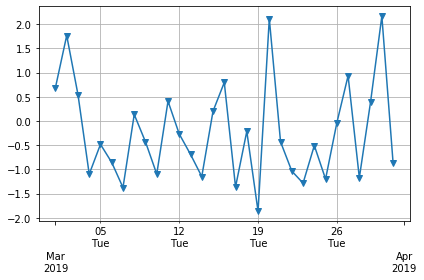

In [30]:
idx = pd.date_range('2019-03-01', '2019-03-31')
s = pd.Series(np.random.randn(len(idx)), index=idx)

fig, ax = plt.subplots()
ax.plot_date(idx.to_pydatetime(), s, 'v-')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%b\n%Y'))
plt.tight_layout()
plt.show()

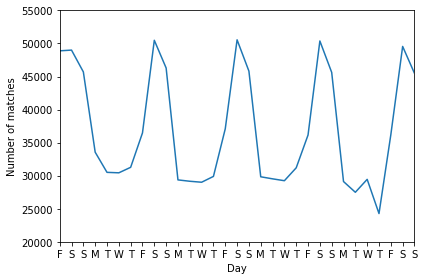

In [6]:
# Plot a line chart.
fig, ax = plt.subplots()
mids_by_date.plot(ax=ax)
plt.xticks(mids_by_date.index, mids_by_date["day"].values)
ax.get_legend().remove()
# ax.xaxis.set_minor_locator(dates.MonthLocator())
# ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%d'))
# ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%d'))
# plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
plt.ylim(ymin=20000, ymax=55000)
plt.xlabel("Day")
plt.ylabel("Number of matches")
plt.tight_layout()
plt.show()
fig.savefig('figs/general_stats/num_of_matches_by_date.png')

In [ ]:
# Plot a line chart.
fig, ax = plt.subplots()
mids_by_date.plot(ax=ax)
# ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(dates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%d\n%b'))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%a'))
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
ax.get_legend().remove()
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
plt.ylim(ymin=20000, ymax=55000)
plt.xlabel("Day")
plt.ylabel("Number of matches")
plt.tight_layout()
plt.show()
# fig.savefig('figs/general_stats/num_of_matches_by_date.png')

In [52]:
# Count the total number of matches.
# The answer should be 1,146,941.
print(mids_by_date['num_of_mids'].sum())

1146941


### 3. Count the number of cheaters by ban date.

In [32]:
# Read the data stored in the S3 bucket and convert it into a dataframe.
PATH_TO_DATA = "s3://social-research-cheating/general-stats/num_of_cheaters.parquet"
num_of_cheaters = spark.read.parquet(PATH_TO_DATA)
num_of_cheaters_df = num_of_cheaters.toPandas()

# Store the dataframe as an excel file.
num_of_cheaters_df.to_csv('num_of_cheaters.csv', index=False)

In [ ]:
num_of_cheaters_df['ban_date'] = pd.to_datetime(num_of_cheaters_df['ban_date'], format='%Y-%m-%d')
num_of_cheaters_df.set_index(['ban_date'], inplace=True)

# Plot a line chart.
fig = plt.plot(num_of_cheaters_df.index, mids_by_date_df['num_of_mids'], 
               color='blue', linestyle='solid')
plt.xlim(xmin=1)
plt.xlim(xmax=31)
plt.xlabel("Date")
plt.ylabel("Number of banned cheaters")
plt.tight_layout()
plt.show() 
fig.savefig('figs/general_stats/num_of_cheaters_by_ban_date.png')

In [ ]:
# Count the total number of cheaters.
# The answer should be 6,161.
print(num_of_cheaters_df['num_of_mids'].sum())